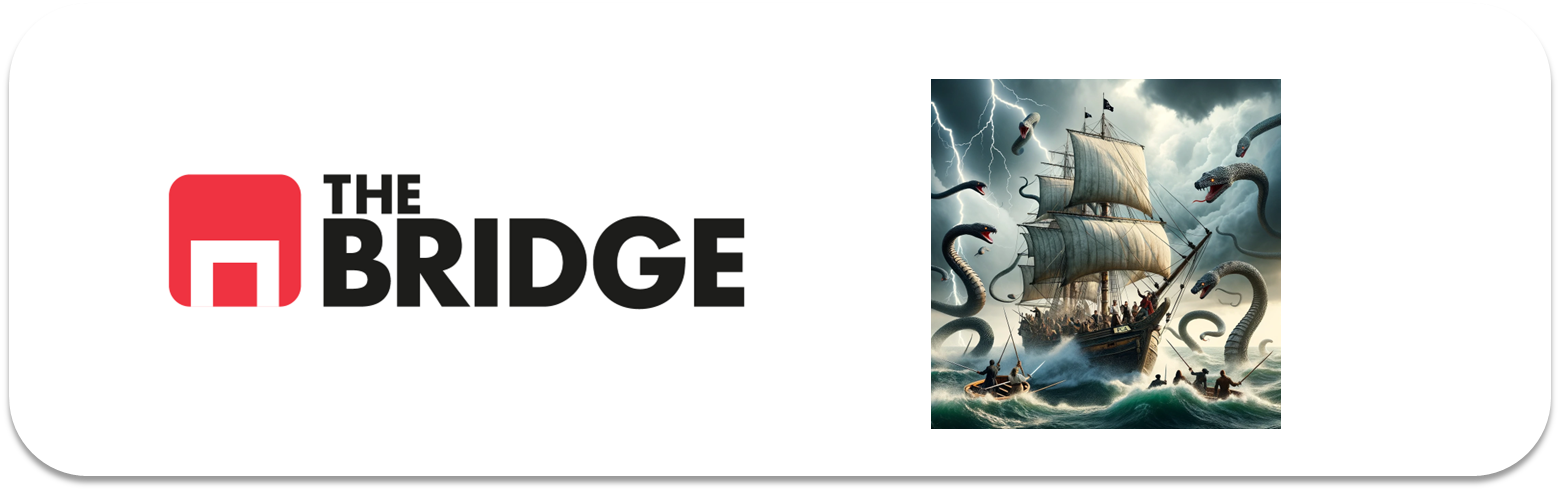

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from bootcampviztools import *
from collections import Counter
from lightgbm import LGBMClassifier
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


In [2]:
# Cargar datos y limpieza

df = pd.read_csv("./data/credit_npo.csv")
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

In [4]:
df.dropna(inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [5]:
# Target

target = "SeriousDlqin2yrs"

In [6]:
# Train y Test

train_set, test_set = train_test_split(df, test_size = 0.2, random_state= 42)

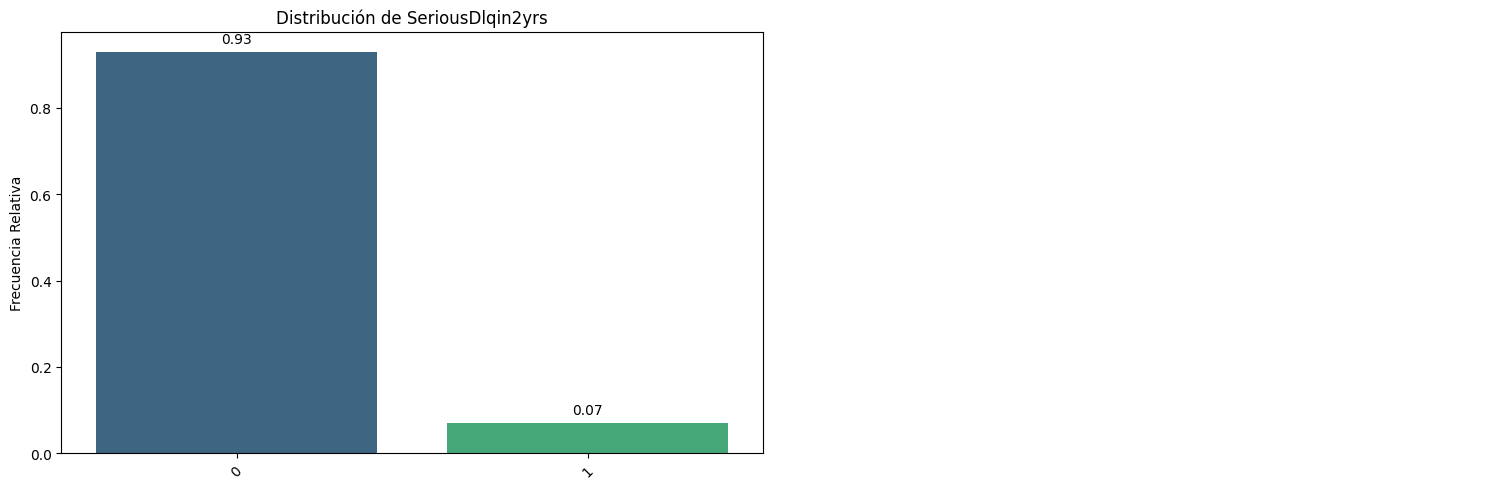

In [7]:
# MiniEDA

pinta_distribucion_categoricas(train_set, [target], relativa = True, mostrar_valores = True)

In [8]:
train_set.describe()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000,9452.000000
mean,0.070144,0.335207,51.491536,0.343314,0.486047,6868.428058,8.794647,0.180279,1.064325,0.152772,0.863415
std,0.255403,0.362233,14.499298,2.930489,2.505031,12580.543336,5.139555,2.889984,1.148156,2.870119,1.158238
min,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.034869,41.000000,0.000000,0.146204,3466.000000,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.179211,51.000000,0.000000,0.297564,5441.000000,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.000000,0.587533,62.000000,0.000000,0.477876,8300.000000,11.000000,0.000000,2.000000,0.000000,2.000000
max,1.000000,6.000000,101.000000,98.000000,96.000000,702500.000000,49.000000,98.000000,19.000000,98.000000,10.000000


In [9]:
features_num = ["RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio", "MonthlyIncome",
                "NumberOfOpenCreditLinesAndLoans", "NumberRealEstateLoansOrLines", "NumberOfDependents"]

In [10]:
train_set["NumberOfTime30-59DaysPastDueNotWorse"].value_counts()

NumberOfTime30-59DaysPastDueNotWorse
0     7856
1     1073
2      318
3      103
4       53
5       20
6       18
98       8
8        2
7        1
Name: count, dtype: int64

In [11]:
train_set["NumberOfTime30-59DaysPastDueNotWorse"] = pd.cut(train_set["NumberOfTime30-59DaysPastDueNotWorse"], bins = [-1, 0, 1, np.inf], labels = [0, 1, 2], right = True).astype(int)
test_set["NumberOfTime30-59DaysPastDueNotWorse"] = pd.cut(test_set["NumberOfTime30-59DaysPastDueNotWorse"], bins = [-1, 0, 1, np.inf], labels = [0, 1, 2], right = True).astype(int) 
train_set["NumberOfTime30-59DaysPastDueNotWorse"].value_counts(True)

NumberOfTime30-59DaysPastDueNotWorse
0    0.831147
1    0.113521
2    0.055332
Name: proportion, dtype: float64

In [12]:
train_set["NumberOfTimes90DaysLate"].value_counts()

NumberOfTimes90DaysLate
0     8919
1      313
2      119
3       44
4       26
5       14
98       8
6        5
7        2
9        1
10       1
Name: count, dtype: int64

In [13]:
train_set["NumberOfTimes90DaysLate"] = (train_set["NumberOfTimes90DaysLate"] > 0).astype(int)
test_set["NumberOfTimes90DaysLate"] = (test_set["NumberOfTimes90DaysLate"] > 0).astype(int)
train_set["NumberOfTimes90DaysLate"].value_counts(True)

NumberOfTimes90DaysLate
0    0.94361
1    0.05639
Name: proportion, dtype: float64

In [14]:
train_set["NumberOfTime60-89DaysPastDueNotWorse"].value_counts()

NumberOfTime60-89DaysPastDueNotWorse
0     8953
1      383
2       76
3       14
4       13
98       8
5        4
11       1
Name: count, dtype: int64

In [15]:
train_set["NumberOfTime60-89DaysPastDueNotWorse"] = (train_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
test_set["NumberOfTime60-89DaysPastDueNotWorse"] = (test_set["NumberOfTime60-89DaysPastDueNotWorse"] > 0).astype(int)
train_set["NumberOfTime60-89DaysPastDueNotWorse"].value_counts(True)

NumberOfTime60-89DaysPastDueNotWorse
0    0.947207
1    0.052793
Name: proportion, dtype: float64

In [16]:
features_cat = ["NumberOfTime30-59DaysPastDueNotWorse", "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"]

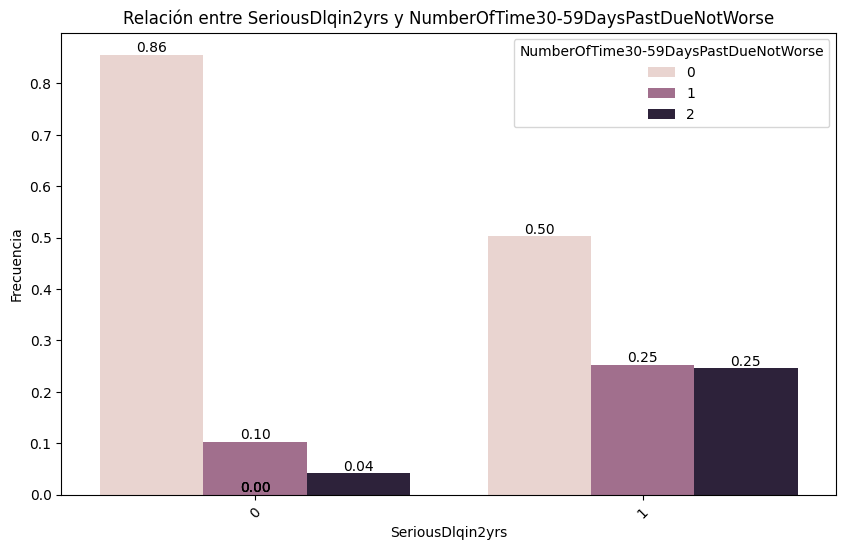

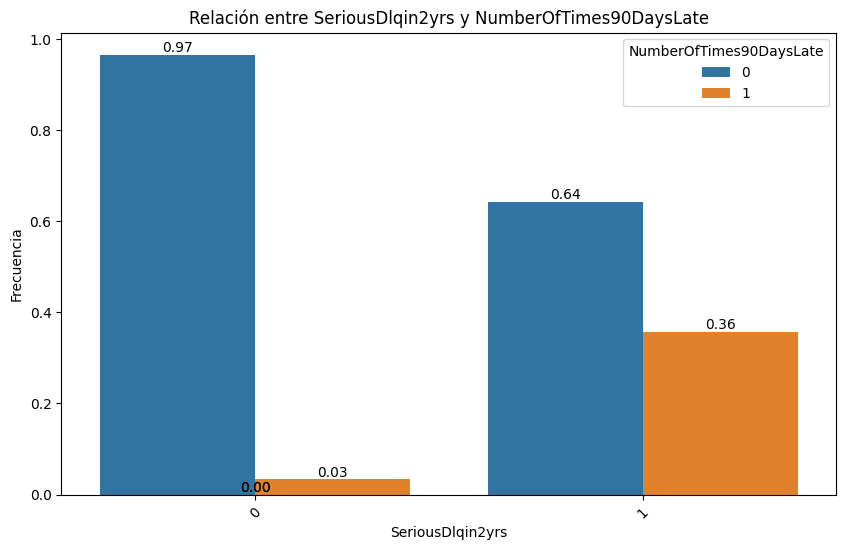

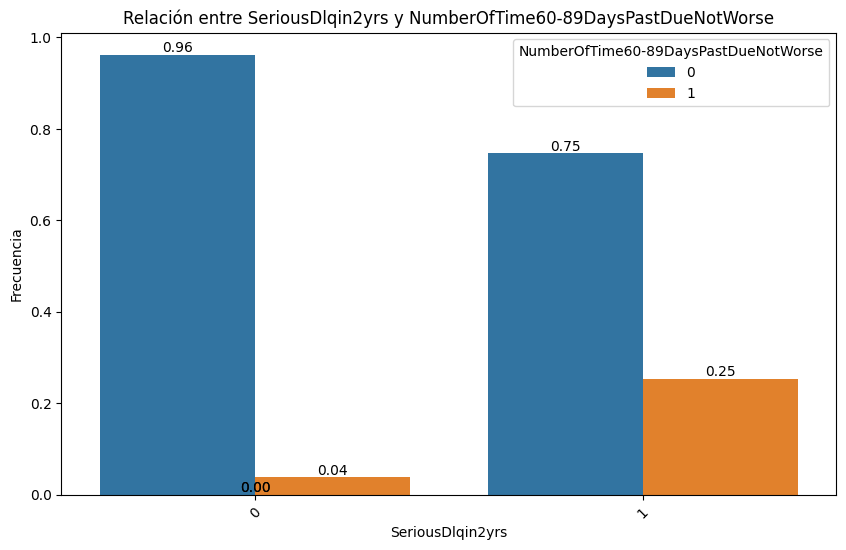

In [17]:
# Análisis visual

for col in features_cat:
    plot_categorical_relationship_fin(train_set, target, col, show_values = True, relative_freq = True)

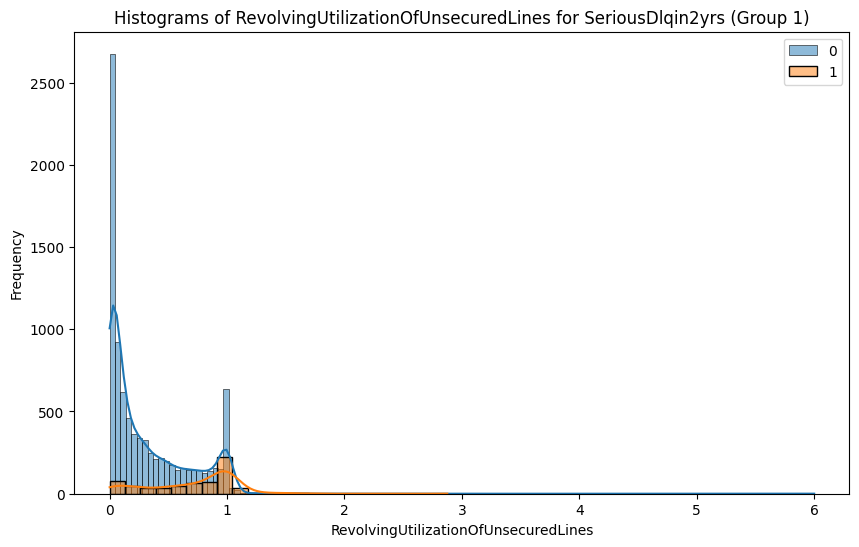

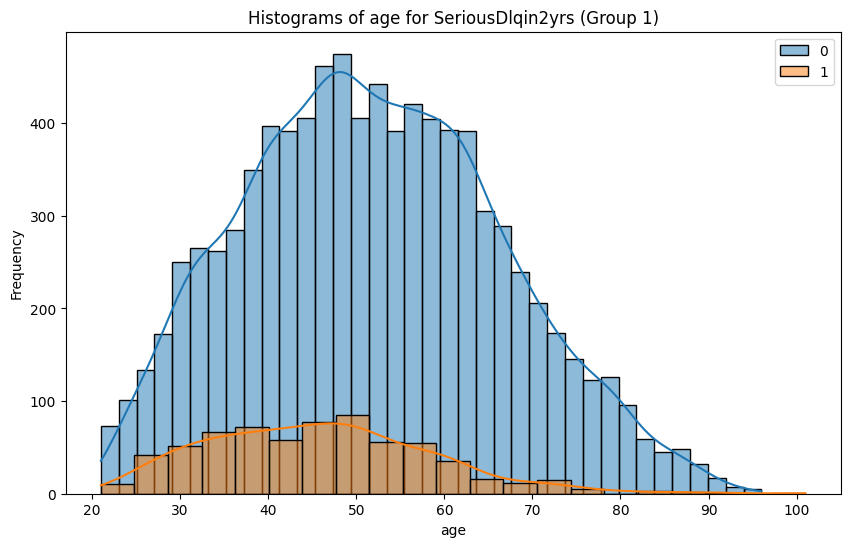

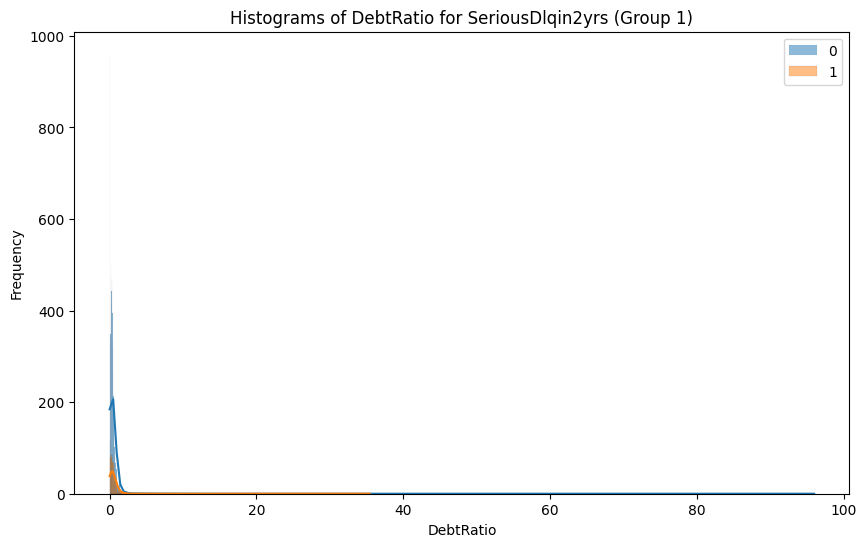

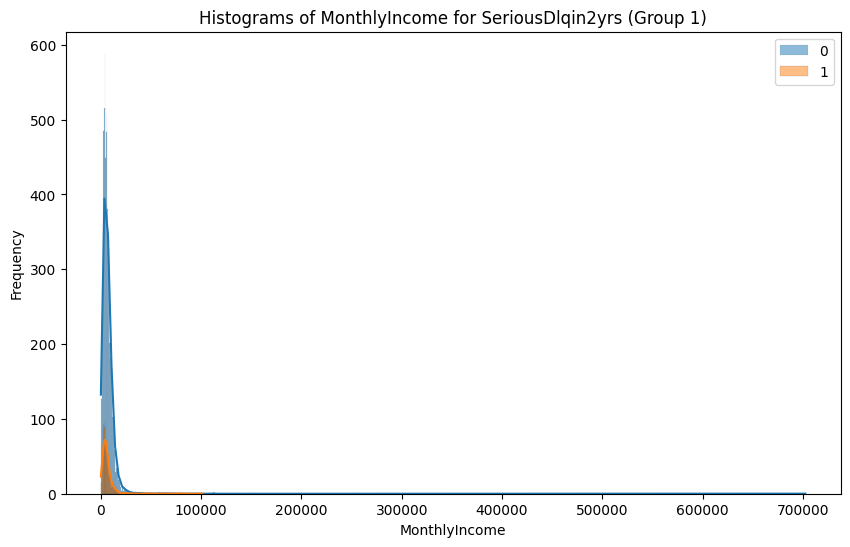

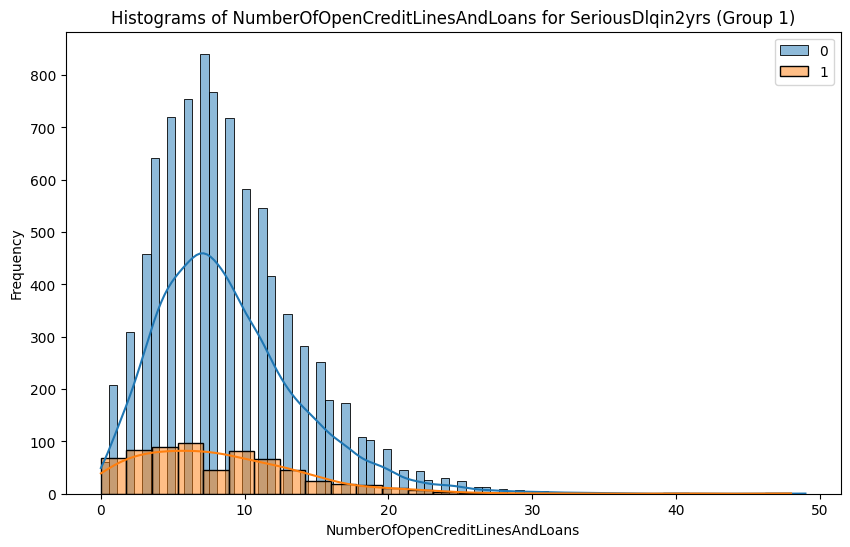

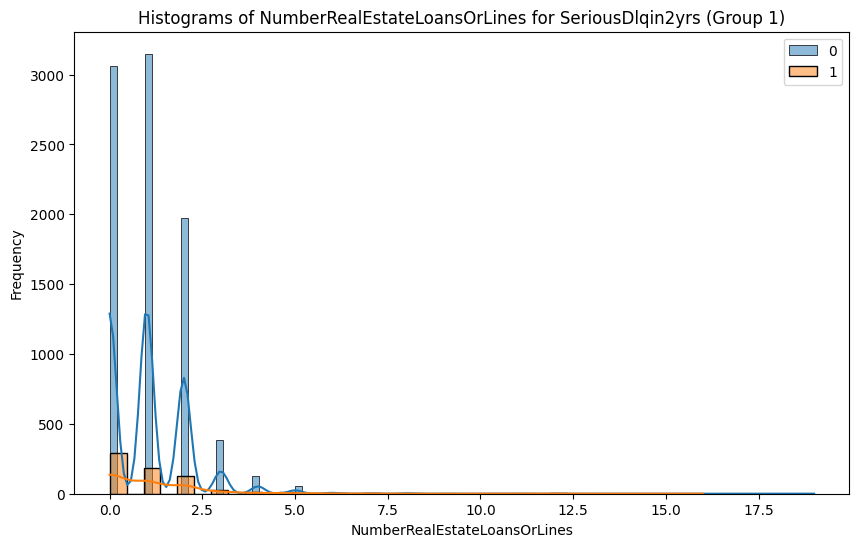

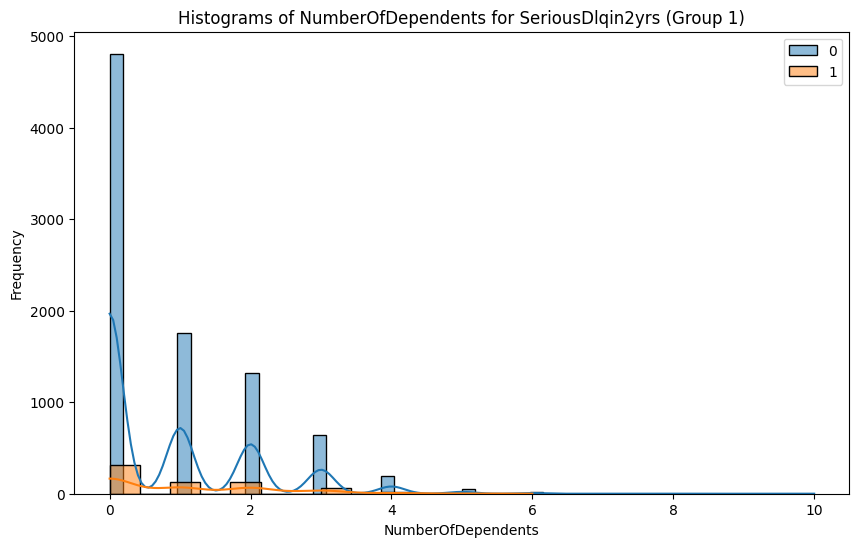

In [18]:
for col in features_num:
    plot_grouped_histograms(train_set, cat_col = target, num_col = col, group_size = 2)

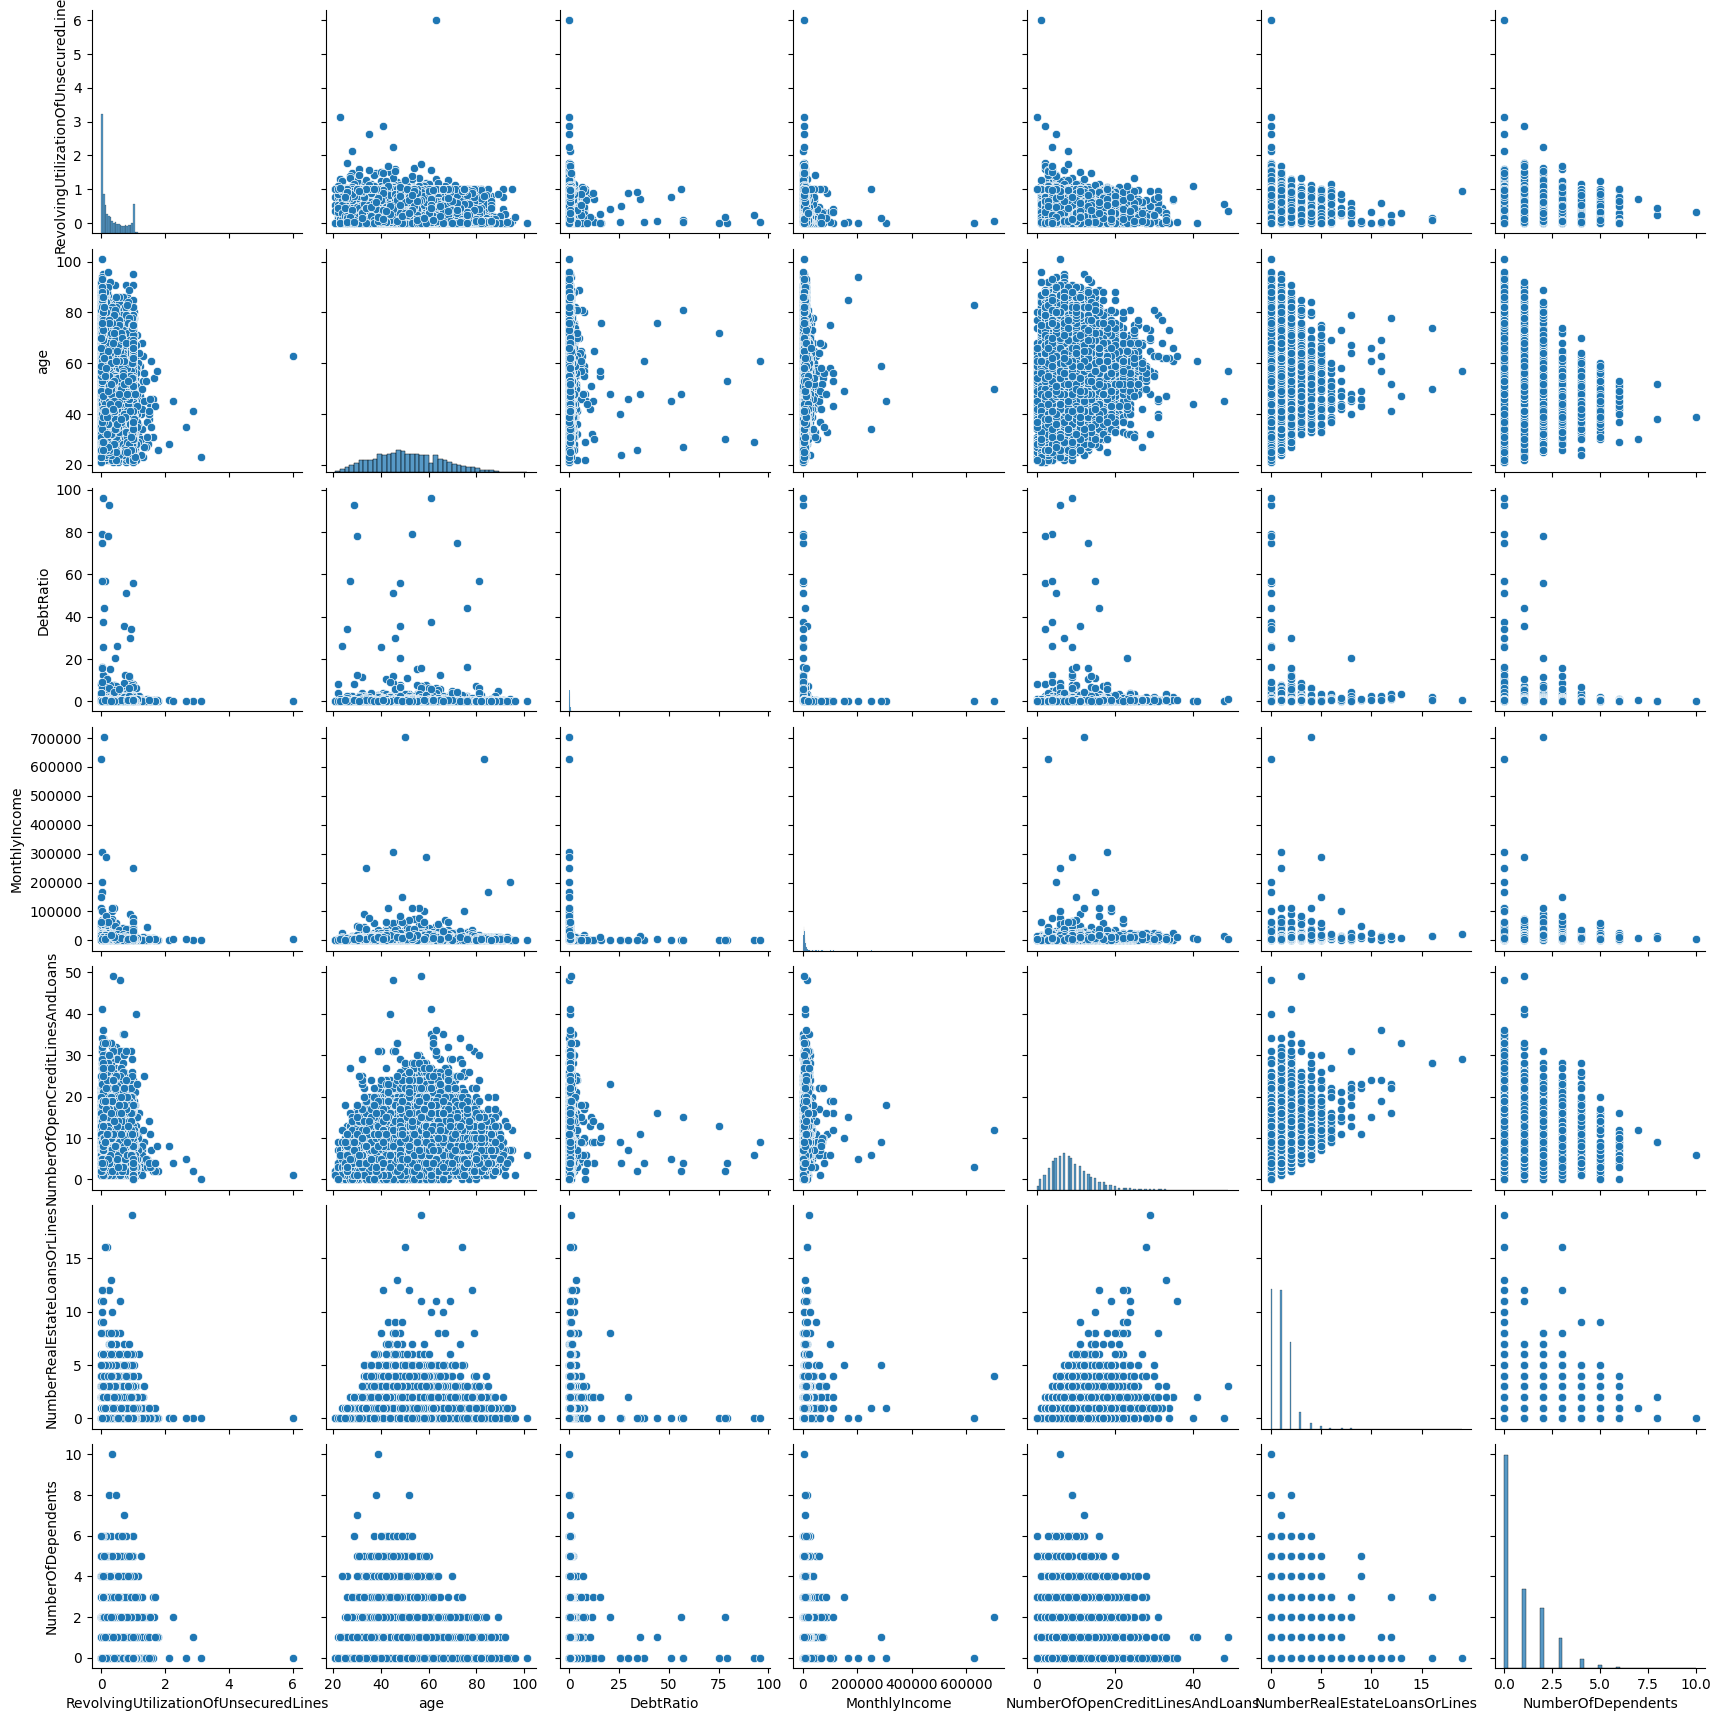

In [19]:
sns.pairplot(train_set[features_num]);

In [20]:
features_visual = features_cat + ["RevolvingUtilizationOfUnsecuredLines", "age"]
features_visual

['NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'RevolvingUtilizationOfUnsecuredLines',
 'age']

In [21]:
# Mutual Information

for col in features_cat:
    print(f"MI({col};{target}):", mutual_info_score(train_set[col], train_set[target]))

MI(NumberOfTime30-59DaysPastDueNotWorse;SeriousDlqin2yrs): 0.024765507782367968
MI(NumberOfTimes90DaysLate;SeriousDlqin2yrs): 0.03421467132247159
MI(NumberOfTime60-89DaysPastDueNotWorse;SeriousDlqin2yrs): 0.017771329855032478


In [22]:
# ANOVA

X_train = train_set[features_num]
y_train = train_set[target]
selector = SelectKBest(f_classif, k = 4)
x_data_kbest = selector.fit_transform(X_train, y_train)
X_train_kbest = pd.DataFrame(x_data_kbest, columns = selector.get_feature_names_out())
X_train_kbest

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfOpenCreditLinesAndLoans,NumberOfDependents
0,0.391240,68.0,13.0,0.0
1,0.906540,59.0,7.0,1.0
2,0.933223,52.0,3.0,3.0
3,0.857859,50.0,9.0,0.0
4,0.000000,61.0,5.0,1.0
...,...,...,...,...
9447,0.397822,53.0,14.0,0.0
9448,0.015171,76.0,4.0,0.0
9449,0.988201,62.0,4.0,0.0
9450,0.122072,41.0,9.0,1.0


In [23]:
features_filtrado = ["NumberOfTimes90DaysLate", "RevolvingUtilizationOfUnsecuredLines", "age", "NumberOfOpenCreditLinesAndLoans", "NumberOfDependents"]
features_filtrado

['NumberOfTimes90DaysLate',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfDependents']

In [24]:
# Selección mediante modelo

features = features_num + features_cat

rf_clf_selector = RandomForestClassifier(random_state = 42)

selector_model = SelectFromModel(estimator = rf_clf_selector, threshold = "median")

selector_model.fit(train_set[features], train_set[target])

SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')

In [25]:
selector_model.get_feature_names_out()

array(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans'], dtype=object)

In [26]:
features_modelo = ["RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio",
       "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans"]
features_modelo

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans']

In [27]:
# RFE

rf_clf_RFE = RandomForestClassifier(random_state = 42)

rfe = RFE(estimator = rf_clf_RFE,
        n_features_to_select = 6,
        step = 1)

rfe.fit(train_set[features], train_set[target])

RFE(estimator=RandomForestClassifier(random_state=42), n_features_to_select=6)

In [28]:
rfe.get_feature_names_out()

array(['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio',
       'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTimes90DaysLate'], dtype=object)

In [29]:
features_rfe = ["RevolvingUtilizationOfUnsecuredLines", "age", "DebtRatio",
       "MonthlyIncome", "NumberOfOpenCreditLinesAndLoans", "NumberOfTimes90DaysLate"]
features_rfe

['RevolvingUtilizationOfUnsecuredLines',
 'age',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate']

In [30]:
# SFS

rf_clf_SFS = RandomForestClassifier(random_state = 42)

sfs_forward = SequentialFeatureSelector(rf_clf_SFS,
                                        n_features_to_select = 6,
                                        cv = 5,
                                        scoring = "balanced_accuracy")

sfs_forward.fit(train_set[features], train_set[target])

SequentialFeatureSelector(estimator=RandomForestClassifier(random_state=42),
                          n_features_to_select=6, scoring='balanced_accuracy')

In [31]:
sfs_forward.get_feature_names_out()

array(['RevolvingUtilizationOfUnsecuredLines', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans',
       'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
       'NumberOfTime60-89DaysPastDueNotWorse'], dtype=object)

In [32]:
features_sfs = ["RevolvingUtilizationOfUnsecuredLines", "MonthlyIncome",
       "NumberOfOpenCreditLinesAndLoans", "NumberOfTime30-59DaysPastDueNotWorse",
       "NumberOfTimes90DaysLate", "NumberOfTime60-89DaysPastDueNotWorse"]
features_sfs

['RevolvingUtilizationOfUnsecuredLines',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse']

In [33]:
# Hard-Voting

lista_features = features_visual + features_filtrado + features_modelo + features_rfe + features_sfs
votos = Counter(lista_features)
votos

Counter({'RevolvingUtilizationOfUnsecuredLines': 5,
         'NumberOfTimes90DaysLate': 4,
         'age': 4,
         'NumberOfOpenCreditLinesAndLoans': 4,
         'MonthlyIncome': 3,
         'NumberOfTime30-59DaysPastDueNotWorse': 2,
         'NumberOfTime60-89DaysPastDueNotWorse': 2,
         'DebtRatio': 2,
         'NumberOfDependents': 1})

In [34]:
features_hard_voting = ["RevolvingUtilizationOfUnsecuredLines", "NumberOfTimes90DaysLate", "age",
                        "NumberOfOpenCreditLinesAndLoans", "MonthlyIncome", "NumberOfTime30-59DaysPastDueNotWorse"]
features_hard_voting

['RevolvingUtilizationOfUnsecuredLines',
 'NumberOfTimes90DaysLate',
 'age',
 'NumberOfOpenCreditLinesAndLoans',
 'MonthlyIncome',
 'NumberOfTime30-59DaysPastDueNotWorse']

In [35]:
# Modelado

nombres = ["Visual", "Filtrado", "Modelo", "RFE", "SFS", "Hard-Voting"]

modelos = {
    "Random Forest" : RandomForestClassifier(random_state = 42),
    "XGBoost" : XGBClassifier(random_state  = 42),
    "LightGBM" : LGBMClassifier(random_state = 42, verbose = -100)
}

features = [
    features_visual,
    features_filtrado,
    features_modelo,
    features_rfe,
    features_sfs,
    features_hard_voting
]

resultados = []

for indice, feature_set in enumerate(features):
    X_train = train_set[feature_set]
    y_train = train_set[target]
    for model_name, modelo in modelos.items():
        metrica = np.mean(cross_val_score(modelo, X_train, y_train, cv = 5, scoring  = "balanced_accuracy"))
        data = {
            "Tipo Feature" : nombres[indice],
            "Modelo" : model_name,
            "Recall Medio" : metrica
        }
        resultados.append(data.copy())

df_resultados = pd.DataFrame(resultados)
df_resultados.sort_values("Recall Medio", ascending = False)

,Tipo Feature,Modelo,Recall Medio
12,SFS,Random Forest,0.598985
13,SFS,XGBoost,0.595114
4,Filtrado,XGBoost,0.594753
14,SFS,LightGBM,0.592291
3,Filtrado,Random Forest,0.591061
16,Hard-Voting,XGBoost,0.590806
1,Visual,XGBoost,0.584962
15,Hard-Voting,Random Forest,0.584874
2,Visual,LightGBM,0.584779
17,Hard-Voting,LightGBM,0.583827


In [36]:
# Optimización y evaluación | SFS - Random Forest

param_grid = {
    "n_estimators" : [50, 100, 150],
    "max_depth" : [5, 10, None],
    "min_samples_split" : [1, 2, 5],
    "min_samples_leaf" : [15, 30, 45],
    "class_weight" : ["balanced", None]
}

rf_clf = RandomForestClassifier(random_state = 42)
rf_grid = GridSearchCV(rf_clf,
                       param_grid = param_grid,
                       cv = 5,
                       scoring = "balanced_accuracy")

rf_grid.fit(train_set[features_sfs], y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [5, 10, None],
                         'min_samples_leaf': [15, 30, 45],
                         'min_samples_split': [1, 2, 5],
                         'n_estimators': [50, 100, 150]},
             scoring='balanced_accuracy')

In [37]:
rf_grid.best_params_

{'class_weight': 'balanced',
 'max_depth': None,
 'min_samples_leaf': 30,
 'min_samples_split': 2,
 'n_estimators': 100}

In [38]:
X_test = test_set[features_sfs]
y_test = test_set[target]

y_pred = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.83      0.90      2197
           1       0.23      0.65      0.34       167

    accuracy                           0.82      2364
   macro avg       0.60      0.74      0.62      2364
weighted avg       0.92      0.82      0.86      2364



### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.

In [39]:
features_pca = df.columns.to_list()

X_train = train_set[features_pca]
X_test = test_set[features_pca]
y_train = train_set[target]
y_test = test_set[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [40]:
modelo_pca = PCA()
modelo_pca.fit(X_train_scaled)
X_train_pca = modelo_pca.transform(X_train_scaled)
X_test_pca = modelo_pca.transform(X_test_scaled)

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.20623199 0.14000442 0.10944156 0.09356582 0.08308666 0.0733004
 0.06873355 0.06312825 0.05794267 0.05505486 0.04950981]


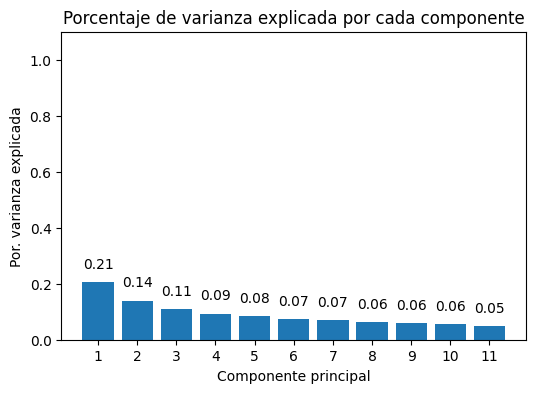

In [41]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df.columns)) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada');

------------------------------------------
Porcentaje de varianza explicada acumulada
------------------------------------------
[0.20623199 0.34623641 0.45567797 0.54924379 0.63233045 0.70563085
 0.7743644  0.83749265 0.89543532 0.95049019 1.        ]


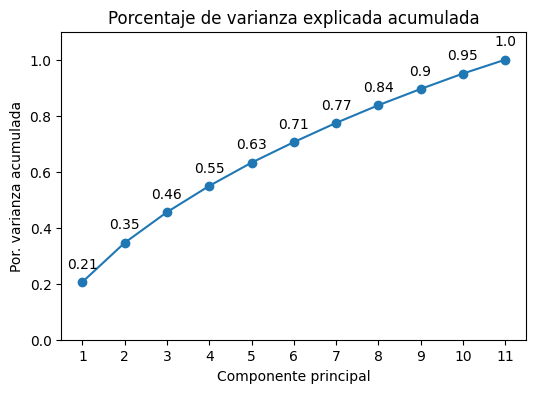

In [42]:
# Porcentaje de varianza explicada acumulada
# ==============================================================================
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(
    np.arange(len(df.columns)) + 1,
    prop_varianza_acum,
    marker = 'o'
)

for x, y in zip(np.arange(len(df.columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )
    
ax.set_ylim(0, 1.1)
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_title('Porcentaje de varianza explicada acumulada')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza acumulada');

In [43]:
rf_clf_pca = RandomForestClassifier(random_state = 42, **rf_grid.best_params_)
scores_pca = []
for num_PCs in range(5, 12):
    print(f"Probando con {num_PCs} componentes:", sep = " ")
    X_train_pca_reduced = X_train_pca[:,:num_PCs]
    score_pca = np.mean(cross_val_score(rf_clf_pca, X_train_pca_reduced, y_train, cv = 5, scoring = "balanced_accuracy"))
    print(score_pca)
    scores_pca.append(score_pca)

Probando con 5 componentes:
0.9400848117936296
Probando con 6 componentes:
0.9613911402169005
Probando con 7 componentes:
0.9827946717752324
Probando con 8 componentes:
0.9852657628870185
Probando con 9 componentes:
0.9965686078874961
Probando con 10 componentes:
0.9989009978142187
Probando con 11 componentes:
0.9986166160822485


In [44]:
rf_clf_pca.fit(X_train_pca, y_train)
y_pred = rf_clf_pca.predict(X_test_pca)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2197
           1       0.99      1.00      0.99       167

    accuracy                           1.00      2364
   macro avg       0.99      1.00      1.00      2364
weighted avg       1.00      1.00      1.00      2364

